In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS

from stargazer.stargazer import Stargazer, LineLocation

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
costplus = pd.read_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\costplus.csv")
costplus.head()

,medication,brand_name,form,retail_price,CP_price
0,Abacavir / Lamivudine (Generic for Epzicom),Epzicom,Tablet,1096.10,71.40
1,Abiraterone Acetate (Generic for Zytiga),Zytiga,Tablet,1093.20,36.60
2,Acarbose (Generic for Precose),Precose,Tablet,43.20,7.50
3,Accu-Chek Guide Me Meter for Diabetic Blood Gl...,NaN,Kit,29.99,10.76
4,Accu-Chek Guide Test Strips for Diabetic Blood...,NaN,Test Strips,29.99,16.79


In [3]:
nadac = pd.read_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\nadac_2019.csv", dtype = {'NDC': str})
nadac.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,ENEMA,00536741551,0.00585,12/19/2018,ML,C/I,Y,"1, 5",G,NaN,NaN,01/02/2019
1,PHENTERMINE 30 MG CAPSULE,51224020250,0.14840,12/19/2018,EA,C/I,N,1,G,NaN,NaN,01/02/2019
2,PENICILLIN VK 125 MG/5 ML SOLN,00093412573,0.06240,11/21/2018,ML,C/I,N,"4, 5",G,NaN,NaN,01/02/2019
3,IRBESARTAN-HYDROCHLOROTHIAZIDE 150-12.5 MG TB,43547033009,0.18722,12/19/2018,EA,C/I,N,1,G,NaN,NaN,01/02/2019
4,AMOX-CLAV 875-125 MG TABLET,00781185220,0.31259,12/19/2018,EA,C/I,N,1,G,NaN,NaN,01/02/2019


In [4]:
med_panel = pd.read_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\med_panel.csv")
med_panel.head()

,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Year,Tot_Spndng,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm,Outlier_Flag
0,8hr Arthritis Pain,Acetaminophen,1,Overall,2017,0.00,0.0,0.0,0.000000,0.000000,0.0
1,8hr Arthritis Pain,Acetaminophen,1,Overall,2018,0.00,0.0,0.0,0.000000,0.000000,0.0
2,8hr Arthritis Pain,Acetaminophen,1,Overall,2019,733.42,11256.0,140.0,0.065158,5.238714,1.0
3,8hr Arthritis Pain,Acetaminophen,1,Overall,2020,426.96,4459.0,46.0,0.095752,9.281739,1.0
4,8hr Arthritis Pain,Acetaminophen,1,Overall,2021,331.69,4642.0,54.0,0.071454,6.142407,1.0


## Percent Change in NADAC of Brand Name and Generic

In [5]:
#Dataframe of NADAC drugs with a corresponding generic
#Caluclating the difference between the generic NADAC and brand name NADAC, as well as the percent change between them
generics_intro = nadac[~(nadac['Corresponding_Generic_Drug_Effective_Date'].isnull())]
generics_intro['nadac_diff'] = generics_intro['Corresponding_Generic_Drug_NADAC_Per_Unit'] - generics_intro['NADAC_Per_Unit'] 
generics_intro['nadac_percent_change'] = generics_intro['nadac_diff']/generics_intro['NADAC_Per_Unit']

In [6]:
#Dataframe of generics_intro, grouping to control for duplicates
#Taking the mean of NADAC related values to account for duplicates
generics_i_uni = generics_intro.groupby(['NDC Description', 'NDC']).agg('mean').sort_values('nadac_percent_change')
generics_i_uni = generics_i_uni.reset_index(level=['NDC Description', 'NDC'])
generics_i_uni

,NDC Description,NDC,NADAC_Per_Unit,Corresponding_Generic_Drug_NADAC_Per_Unit,nadac_diff,nadac_percent_change
0,ATIVAN 1 MG TABLET,00187006410,31.640337,0.040266,-31.600071,-0.998727
1,ATIVAN 1 MG TABLET,00187006401,31.640337,0.040266,-31.600071,-0.998727
2,ATIVAN 0.5 MG TABLET,00187006301,22.687410,0.029450,-22.657960,-0.998702
3,AMBIEN 5 MG TABLET,00024540131,16.917960,0.028688,-16.889272,-0.998304
4,MOBIC 15 MG TABLET,00597003001,12.363243,0.021021,-12.342223,-0.998300
...,...,...,...,...,...,...
1281,PACERONE 400 MG TABLET,00245014501,1.838530,3.003601,1.165071,0.633697
1282,RETIN-A 0.1% CREAM,00187516445,1.807655,3.131097,1.323442,0.743206
1283,DERMA-SMOOTHE-FS SCALP OIL,68791010204,0.283769,0.541236,0.257467,0.907289
1284,METHYLIN 10 MG/5 ML SOLUTION,59630075550,0.190640,0.364837,0.174197,0.913747


In [7]:
#Numerical summary
generics_i_uni['NADAC_Per_Unit'].describe(), generics_i_uni['Corresponding_Generic_Drug_NADAC_Per_Unit'].describe(), generics_i_uni['nadac_percent_change'].describe()

(count    1286.000000
 mean       16.172719
 std        41.480554
 min         0.004627
 25%         1.189129
 50%         6.875232
 75%        13.622058
 max       471.558810
 Name: NADAC_Per_Unit, dtype: float64,
 count    1286.000000
 mean        4.514114
 std        19.310159
 min         0.002872
 25%         0.144370
 50%         0.387976
 75%         2.765549
 max       330.857843
 Name: Corresponding_Generic_Drug_NADAC_Per_Unit, dtype: float64,
 count    1286.000000
 mean       -0.695883
 std         0.291593
 min        -0.998727
 25%        -0.956747
 50%        -0.759704
 75%        -0.499422
 max         1.678817
 Name: nadac_percent_change, dtype: float64)

The numerical summaries indicate that all of these distributions are highly skewed right. In particular, the distributions of the NADACs have particularly high variances.

<AxesSubplot:xlabel='nadac_percent_change', ylabel='Density'>

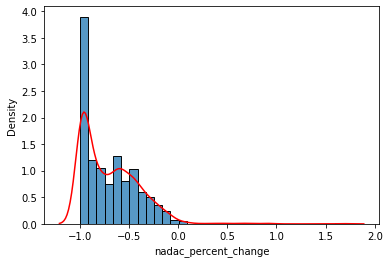

In [8]:
sns.histplot(x = generics_i_uni['nadac_percent_change'], stat = 'density')
sns.kdeplot(generics_i_uni['nadac_percent_change'], color="r")

The KDE plot shows that the data are highly right-skewed, indicating that while most drugs decrease in price when generics are introduced, a significant proportion of them experience a drastic decrease in price once the corresponding generic is introduced, indicated by the highest bar being around -1.0. Interestingly, some drugs have positive percent change values, which indicates that the NADAC increased for these drugs when generics were introduced. We can filter for and examine these:

In [9]:
positive_perc_change = generics_i_uni[generics_i_uni['nadac_diff'] > 0].sort_values('nadac_diff')
positive_perc_change

,NDC Description,NDC,NADAC_Per_Unit,Corresponding_Generic_Drug_NADAC_Per_Unit,nadac_diff,nadac_percent_change
1272,CARNITOR 100 MG/ML ORAL SOLN,54482014508,0.274550,0.291208,0.016658,0.060674
1278,LORCET HD 10-325 MG TABLET,51862058701,0.081194,0.115858,0.034664,0.445923
1279,LORCET HD 10-325 MG TABLET,51862058705,0.081194,0.115858,0.034664,0.445923
1277,DERMA-SMOOTHE-FS BODY OIL,68791010104,0.296230,0.393038,0.096808,0.326801
1274,PACERONE 100 MG TABLET,00245014430,1.890357,2.002333,0.111976,0.067075
1275,PACERONE 100 MG TABLET,00245014401,1.890357,2.002333,0.111976,0.067075
1284,METHYLIN 10 MG/5 ML SOLUTION,59630075550,0.190640,0.364837,0.174197,0.913747
1270,KLOR-CON 20 MEQ PACKET,00245036030,5.271647,5.475649,0.204002,0.056848
1271,KLOR-CON 20 MEQ PACKET,00245036001,5.271647,5.475649,0.204002,0.056848
1283,DERMA-SMOOTHE-FS SCALP OIL,68791010204,0.283769,0.541236,0.257467,0.907289


In [10]:
positive_perc_change.shape

(15, 6)

In [11]:
positive_perc_change['nadac_percent_change'].describe()

count    15.000000
mean      0.473226
std       0.462928
min       0.056848
25%       0.063918
50%       0.445923
75%       0.688452
max       1.678817
Name: nadac_percent_change, dtype: float64

15 drugs have a positive change in NADAC compared to the generic. While most of these drugs experience a marginal increase for the generic, some of these increase more than 30% percent. In particular, two drugs increase by more than 90%, and one drug increases by 167%. 

# Cost Plus: Looking At The Relationship Between Brand Name Price and Manufacturing Costs

Since Cost Plus is very transparent regarding their pricing, I seek to use the Cost Plus prices as a proxy for manufacturing costs. For each drug, there is a $3 fee added to account for pharmacy labor, and shipping costs are not included in the prices reported. Additionally, there is a 15% markup. To isolate the manufacturing cost, I first subtract 3 from all of the prices, and divide each price by 1.15.

In [12]:
costplus = pd.read_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\costplus.csv")
costplus.head()

,medication,brand_name,form,retail_price,CP_price
0,Abacavir / Lamivudine (Generic for Epzicom),Epzicom,Tablet,1096.10,71.40
1,Abiraterone Acetate (Generic for Zytiga),Zytiga,Tablet,1093.20,36.60
2,Acarbose (Generic for Precose),Precose,Tablet,43.20,7.50
3,Accu-Chek Guide Me Meter for Diabetic Blood Gl...,NaN,Kit,29.99,10.76
4,Accu-Chek Guide Test Strips for Diabetic Blood...,NaN,Test Strips,29.99,16.79


In [13]:
costplus['manuf_cost'] = (costplus['CP_price'] - 3)/1.15

In [14]:
costplus

,medication,brand_name,form,retail_price,CP_price,manuf_cost
0,Abacavir / Lamivudine (Generic for Epzicom),Epzicom,Tablet,1096.10,71.40,59.478261
1,Abiraterone Acetate (Generic for Zytiga),Zytiga,Tablet,1093.20,36.60,29.217391
2,Acarbose (Generic for Precose),Precose,Tablet,43.20,7.50,3.913043
3,Accu-Chek Guide Me Meter for Diabetic Blood Gl...,NaN,Kit,29.99,10.76,6.747826
4,Accu-Chek Guide Test Strips for Diabetic Blood...,NaN,Test Strips,29.99,16.79,11.991304
...,...,...,...,...,...,...
437,Warfarin (Generic for Coumadin),Coumadin,Tablet,9.99,4.80,1.565217
438,Ziprasidone HCl (Generic for Geodon),Geodon,Capsule,175.50,6.90,3.391304
439,Zolmitriptan (Generic for Zomig),Zomig,Blister Pack of 3 Tablets,120.32,6.73,3.243478
440,Zolmitriptan (Generic for Zomig ZMT),NaN,Blister Pack of 3 ODT Tablets,135.91,9.12,5.321739


I seek to investigate the relationship between manufacturing cost and the actual brand name price of the drug. To answer this question, I will run a linear regression of manufacturing cost on the retail price (**From Cost Plus: The retail price listed on our website is an average of retail prices across other pharmacies that is sourced from third-party data. This information is published at the time we add the medication so may not reflect current market prices.**), and then also perform another regression matching up the drugs in the Cost Plus data to another dataset.

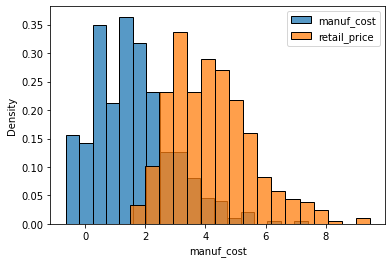

In [15]:
sns.histplot(x = np.log(costplus['manuf_cost']), stat = 'density', label = 'manuf_cost')
sns.histplot(x = np.log(costplus['retail_price']), stat = 'density', label = 'retail_price')
plt.legend()

Text(27.125, 0.5, 'ln(retail_price)')

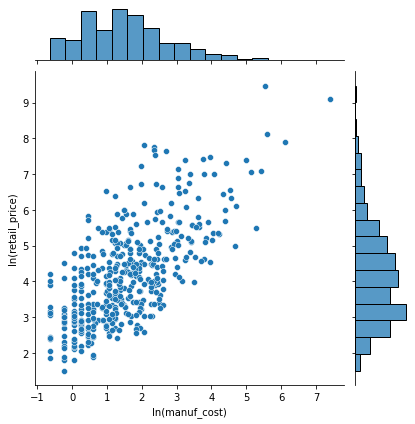

In [16]:
sns.jointplot(x = np.log(costplus['manuf_cost']), y = np.log(costplus['retail_price']))
plt.xlabel('ln(manuf_cost)')
plt.ylabel('ln(retail_price)')

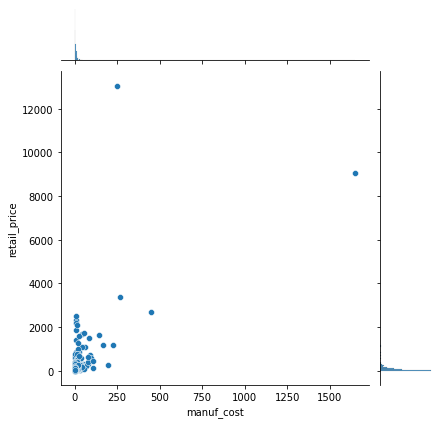

In [17]:
sns.jointplot(x = costplus['manuf_cost'], y = costplus['retail_price'])

In [18]:
Y = np.log(costplus['retail_price'])
X = np.log(costplus['manuf_cost'])
X = sm.add_constant(X)
model = sm.OLS(Y,X, missing = 'drop')
#Heteroskedasticity robust SE
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           retail_price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     446.7
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           6.03e-69
Time:                        20:56:16   Log-Likelihood:                -614.41
No. Observations:                 442   AIC:                             1233.
Df Residuals:                     440   BIC:                             1241.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0678      0.066     46.649      0.0

With an R-squared value of .483 and highly significant coefficients, it appears that manufacturing costs explains a significant proportion of the variance of retail prices of the drugs in Cost Plus. We can also try to further validate this by utilizing other data. However, one thing to note is that if medicine was priced with a lot of the costs in mind, then we should expect a coefficient that is much closer to 1. However, this is not the case, and the 95% confidence interval is far from it as well. Also, the manufacturing costs only account for half of the variance of the retail price, indicating that there are other highly relevant factors other than manufacturing-related costs which account for the final retail price. 

To attempt to generalize this concept, let's assume that the price of every drug can be decomposed into manufacuring costs, a percentage markup from those manufacturing costs, and a fixed labor cost. In the case of Cost Plus, we know the associated manufacturing costs and the labor cost, and so we can estimate the markup for each drug:

In [19]:
costplus['markup'] = (((costplus['retail_price'] - 3)/(costplus['manuf_cost'])) - 1) * 100 #subtracting 1 gives it in percentage terms

In [20]:
costplus

,medication,brand_name,form,retail_price,CP_price,manuf_cost,markup
0,Abacavir / Lamivudine (Generic for Epzicom),Epzicom,Tablet,1096.10,71.40,59.478261,1737.814327
1,Abiraterone Acetate (Generic for Zytiga),Zytiga,Tablet,1093.20,36.60,29.217391,3631.339286
2,Acarbose (Generic for Precose),Precose,Tablet,43.20,7.50,3.913043,927.333333
3,Accu-Chek Guide Me Meter for Diabetic Blood Gl...,NaN,Kit,29.99,10.76,6.747826,299.980670
4,Accu-Chek Guide Test Strips for Diabetic Blood...,NaN,Test Strips,29.99,16.79,11.991304,125.079768
...,...,...,...,...,...,...,...
437,Warfarin (Generic for Coumadin),Coumadin,Tablet,9.99,4.80,1.565217,346.583333
438,Ziprasidone HCl (Generic for Geodon),Geodon,Capsule,175.50,6.90,3.391304,4986.538462
439,Zolmitriptan (Generic for Zomig),Zomig,Blister Pack of 3 Tablets,120.32,6.73,3.243478,3517.104558
440,Zolmitriptan (Generic for Zomig ZMT),NaN,Blister Pack of 3 ODT Tablets,135.91,9.12,5.321739,2397.491830


In [21]:
#CSV for RStudio
#costplus.to_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\costplus_fin.csv", index = False)

<AxesSubplot:xlabel='markup', ylabel='Density'>

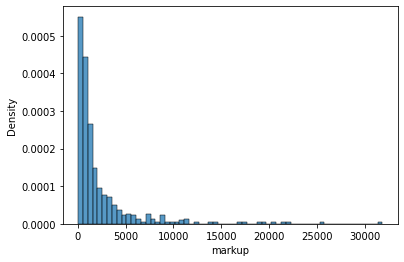

In [22]:
sns.histplot(x = costplus['markup'], stat = 'density')

<AxesSubplot:xlabel='markup', ylabel='Density'>

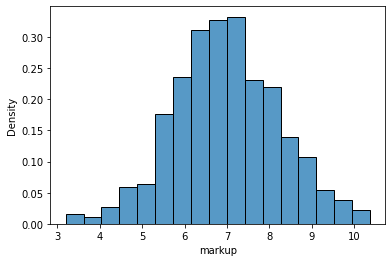

In [23]:
sns.histplot(x = np.log(costplus['markup']), stat = 'density')

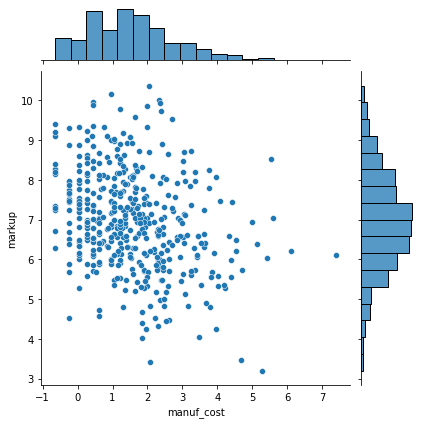

In [24]:
sns.jointplot(x = np.log(costplus['manuf_cost']), y = np.log(costplus['markup']))

In [25]:
#Markup on manufacturing cost
ln_markup = np.log(costplus['markup'])
ln_manuf_cost = np.log(costplus['manuf_cost'])
ln_manuf_cost = sm.add_constant(ln_manuf_cost)
model = sm.OLS(ln_markup, ln_manuf_cost, missing = 'drop')
#Heteroskedasticity robust SE
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 markup   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     39.88
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           6.60e-10
Time:                        20:56:17   Log-Likelihood:                -701.58
No. Observations:                 442   AIC:                             1407.
Df Residuals:                     440   BIC:                             1415.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4106      0.083     89.493      0.0

Interestingly, the coefficient on ln(manuf_cost) is negative. In particular, this indicates
that for a 1% change in manuf cost, markup decreases by .275%, on average. Similarly to the
first regression, the markup is quite inelastic to changes in manufacturing cost, to an even
higher degree compared to the retail price. On first glance, the sign on the coefficient doesn’t
make sense, since we would expect that an increase in manufacturing cost should increase
the markup, since the manufacturer would want to recoup more of the manufacturing cost.
However, the first regression suggests that has the manufacturing cost increases, the
retail price increases as well, although not as much as the manufacturing cost. Therefore,
the manufacturing cost increases faster than the retail price on average, and so an increase in
the manufacturing costs results in a decrease the markup. However, the R2 is quite low for
the second regression, which indicates that manufacturing costs explain little of the variance
in the markup.

In [26]:
#Generates LaTeX code for regression table
markup_OLS = Stargazer([results])
#print(markup_OLS.render_latex())

# Analysis of the Medicaid Data

In [27]:
med_panel = pd.read_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\med_panel.csv")

In [28]:
#13,751 * 5 total observations (13,751 units, 5 time periods)
med_panel.shape

(80730, 11)

In [29]:
med_panel

,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Year,Tot_Spndng,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm,Outlier_Flag
0,8hr Arthritis Pain,Acetaminophen,1,Overall,2017,0.00,0.0,0.0,0.000000,0.000000,0.0
1,8hr Arthritis Pain,Acetaminophen,1,Overall,2018,0.00,0.0,0.0,0.000000,0.000000,0.0
2,8hr Arthritis Pain,Acetaminophen,1,Overall,2019,733.42,11256.0,140.0,0.065158,5.238714,1.0
3,8hr Arthritis Pain,Acetaminophen,1,Overall,2020,426.96,4459.0,46.0,0.095752,9.281739,1.0
4,8hr Arthritis Pain,Acetaminophen,1,Overall,2021,331.69,4642.0,54.0,0.071454,6.142407,1.0
...,...,...,...,...,...,...,...,...,...,...,...
80725,Zyvox,Linezolid In Dextrose 5%,1,Phar-Nov/Pfizer,2017,51872.75,185291.0,152.0,0.279953,341.268092,1.0
80726,Zyvox,Linezolid In Dextrose 5%,1,Phar-Nov/Pfizer,2018,24927.29,102880.0,143.0,0.242295,174.316713,1.0
80727,Zyvox,Linezolid In Dextrose 5%,1,Phar-Nov/Pfizer,2019,24891.40,123138.0,138.0,0.202142,180.372464,0.0
80728,Zyvox,Linezolid In Dextrose 5%,1,Phar-Nov/Pfizer,2020,12952.81,82628.0,162.0,0.156761,79.955617,0.0


In [30]:
#Filtering for overall, not outlier
med_panel_agg = med_panel[(med_panel['Mftr_Name'] == 'Overall') & (med_panel['Outlier_Flag'] == 0) & (med_panel['Tot_Spndng'] > 0)]

In [31]:
#Filtering for not overall, not outlier
med_panel_ind = med_panel[(med_panel['Mftr_Name'] != 'Overall') & (med_panel['Outlier_Flag'] == 0) & (med_panel['Tot_Spndng'] > 0)]

In [32]:
med_panel_agg.head()

,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Year,Tot_Spndng,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm,Outlier_Flag
60,Abacavir,Abacavir Sulfate,6,Overall,2017,4855932.38,1454929.000,22799.0,3.629691,212.988832,0.0
61,Abacavir,Abacavir Sulfate,6,Overall,2018,3000495.65,1870113.000,20097.0,2.298001,149.300674,0.0
62,Abacavir,Abacavir Sulfate,6,Overall,2019,2446359.81,1621617.000,15983.0,2.277064,153.060114,0.0
63,Abacavir,Abacavir Sulfate,6,Overall,2020,1721889.97,1364799.294,12949.0,1.868880,132.974745,0.0
64,Abacavir,Abacavir Sulfate,6,Overall,2021,1404972.50,1239824.000,10708.0,1.758827,131.207742,0.0


In [33]:
med_panel_agg.to_csv("C:\\Users\\ttrap\\Desktop\\ECON 191\\med_panel_agg.csv", index = False)

## Summary Statistics

In [34]:
med_panel_agg.shape

(12740, 11)

In [35]:
med_panel_agg['Tot_Mftr'].describe()

count    12740.000000
mean         3.337834
std          4.789239
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         44.000000
Name: Tot_Mftr, dtype: float64

In [36]:
med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd'].describe()

count    12740.000000
mean       283.403852
std       1699.071105
min          0.000329
25%          0.692086
50%          4.447220
75%         27.832597
max      39359.911863
Name: Avg_Spnd_Per_Dsg_Unt_Wghtd, dtype: float64

In [37]:
med_panel_agg['Tot_Clms'].describe()

count    1.274000e+04
mean     2.512713e+05
std      1.039414e+06
min      3.600000e+01
25%      1.533000e+03
50%      8.156500e+03
75%      5.508175e+04
max      1.508415e+07
Name: Tot_Clms, dtype: float64

In [38]:
med_panel_agg['Avg_Spnd_Per_Clm'].describe()

count     12740.000000
mean       2097.987817
std        7255.865162
min           0.894512
25%          35.361067
50%         183.802171
75%         681.247235
max      187153.849760
Name: Avg_Spnd_Per_Clm, dtype: float64

In [39]:
med_panel_agg['Tot_Spndng'].describe()

count    1.274000e+04
mean     2.633088e+07
std      9.437335e+07
min      2.167100e+02
25%      3.620074e+05
50%      2.170707e+06
75%      1.386572e+07
max      2.730141e+09
Name: Tot_Spndng, dtype: float64

<AxesSubplot:xlabel='Tot_Clms', ylabel='Density'>

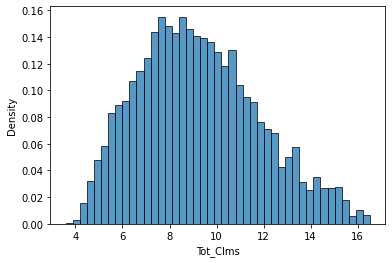

In [40]:
sns.histplot(x = np.log(med_panel_agg['Tot_Clms']), stat = 'density')

First, let's compare the effect of the total number of manufacturers on the average cost per dosage and the average cost per claim naively: we don't consider the time index for these first regressions.

### Running into trouble with regressing cost variables on total manufacturers: create dummies for total manufacturers, since the effect of manufacturers is nonlinear.

The effect of the number of manufacturers on the average cost is non-linear, so we will run the regression by creating dummies for each of the values of the number of manufacturers, except for 1. 

In [41]:
#Creating dummies
manuf_dummies = pd.get_dummies(med_panel_agg['Tot_Mftr'])
manuf_dummies = manuf_dummies.drop(columns = 1)

<AxesSubplot:xlabel='Tot_Mftr', ylabel='Avg_Spnd_Per_Dsg_Unt_Wghtd'>

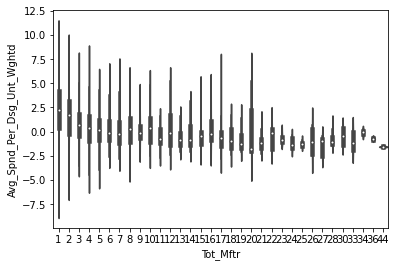

In [42]:
sns.violinplot(x = med_panel_agg['Tot_Mftr'] , y = np.log(med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd']))

This violin plot shows the distribution of the log of the average cost per dosage unit for each number of manufacturers. It is somewhat difficult to get an idea of the relationship, so we can also calculate the mean average cost per unit for each number of manufacturers and plot it:

In [43]:
med_panel_agg.groupby('Tot_Mftr').agg('mean').reset_index()

,Tot_Mftr,Year,Tot_Spndng,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm,Outlier_Flag
0,1,2019.112669,3.301522e+07,3.676089e+06,5.199586e+04,431.302987,3098.161517,0.0
1,2,2019.095569,1.176625e+07,3.866811e+06,4.036576e+04,108.274121,922.328824,0.0
2,3,2019.076779,3.918819e+06,8.135092e+06,5.993998e+04,26.694474,325.579292,0.0
3,4,2019.055814,2.566054e+06,3.646651e+07,6.172056e+04,16.297166,388.609648,0.0
4,5,2019.043614,5.063174e+06,6.952504e+07,8.114496e+04,5.811611,211.720653,0.0
5,6,2019.066445,4.959821e+06,6.632043e+06,1.520170e+05,10.779872,358.598233,0.0
6,7,2019.054795,6.585734e+06,2.299212e+07,2.367702e+05,15.061554,404.587266,0.0
7,8,2019.080153,1.946026e+07,4.677243e+07,6.037263e+05,11.343392,400.289380,0.0
8,9,2018.986364,1.464189e+07,2.791864e+07,5.225579e+05,2.235584,93.300273,0.0
9,10,2019.023585,2.016587e+07,3.601650e+07,8.832395e+05,7.665514,253.942607,0.0


Text(0, 0.5, 'Mean Average Spending Per Dosage Unit')

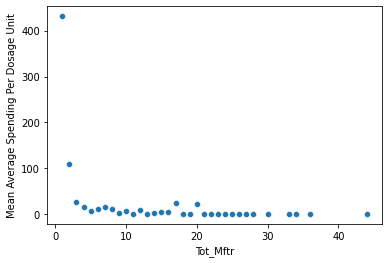

In [44]:
sns.scatterplot(data = med_panel_agg.groupby('Tot_Mftr').agg('mean').reset_index(), x = 'Tot_Mftr', y = 'Avg_Spnd_Per_Dsg_Unt_Wghtd')
plt.ylabel('Mean Average Spending Per Dosage Unit')

The scatterplot shows that the average cost per unit is quite high for drugs with only one manufacturer. As soon as there are two manufacturers, the average cost drastically decreases. The increase from 2 to 3 manufacturers results in another significant decrease, and the decrease resulting from an increase in the number of manufacturers is at best marginal for greater than 3 manufacturers.

In [45]:
#Naive Regression on average cost per dosage
avg_cost = np.log(med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd'])
num_manuf = manuf_dummies
num_manuf = sm.add_constant(num_manuf)
cost_on_manuf = sm.OLS(avg_cost, num_manuf)
#Heteroskedasticity robust SE
r_costdsg_on_manuf = cost_on_manuf.fit(cov_type='HC3')
print(r_costdsg_on_manuf.summary())

                                OLS Regression Results                                
Dep. Variable:     Avg_Spnd_Per_Dsg_Unt_Wghtd   R-squared:                       0.154
Model:                                    OLS   Adj. R-squared:                  0.152
Method:                         Least Squares   F-statistic:                     301.3
Date:                        Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                                20:56:19   Log-Likelihood:                -29684.
No. Observations:                       12740   AIC:                         5.943e+04
Df Residuals:                           12707   BIC:                         5.968e+04
Df Model:                                  32                                         
Covariance Type:                          HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

<AxesSubplot:xlabel='Tot_Mftr', ylabel='Avg_Spnd_Per_Clm'>

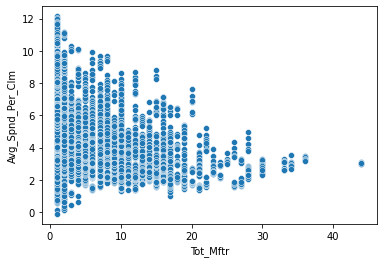

In [46]:
sns.scatterplot(x = med_panel_agg['Tot_Mftr'] , y = np.log(med_panel_agg['Avg_Spnd_Per_Clm']))

In [47]:
#Naive Regression on average cost per claim
avg_cost_clm = np.log(med_panel_agg['Avg_Spnd_Per_Clm'])
num_manuf = manuf_dummies
num_manuf = sm.add_constant(num_manuf)
cost_clm_on_manuf = sm.OLS(avg_cost_clm, num_manuf)
#Heteroskedasticity robust SE
results = cost_clm_on_manuf.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Spnd_Per_Clm   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     302.1
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:19   Log-Likelihood:                -26363.
No. Observations:               12740   AIC:                         5.279e+04
Df Residuals:                   12707   BIC:                         5.304e+04
Df Model:                          32                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9684      0.024    249.627      0.0

We now try controlling for time fixed effects by creating another set of indicators for time, where we omit the indicator for 2017 to avoid multicollinearity.

In [48]:
time_dummies = pd.get_dummies(med_panel_agg['Year'])
time_dummies = time_dummies.drop(columns = 2017)

In [49]:
all_dummies = time_dummies.join(manuf_dummies)

In [50]:
med_panel_agg[med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd'] > 0]['Avg_Spnd_Per_Dsg_Unt_Wghtd'].describe()

count    12740.000000
mean       283.403852
std       1699.071105
min          0.000329
25%          0.692086
50%          4.447220
75%         27.832597
max      39359.911863
Name: Avg_Spnd_Per_Dsg_Unt_Wghtd, dtype: float64

In [51]:
#Regression including time-fixed effects
avg_cost = np.log(med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd'] )
dummies = sm.add_constant(all_dummies)
cost_on_manuf_tf = sm.OLS(avg_cost, dummies)
#Heteroskedasticity robust SE
r_costdsg_on_manuf_tf = cost_on_manuf_tf.fit(cov_type='HC3')
print(r_costdsg_on_manuf_tf.summary())

                                OLS Regression Results                                
Dep. Variable:     Avg_Spnd_Per_Dsg_Unt_Wghtd   R-squared:                       0.155
Model:                                    OLS   Adj. R-squared:                  0.153
Method:                         Least Squares   F-statistic:                     174.7
Date:                        Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                                20:56:19   Log-Likelihood:                -29674.
No. Observations:                       12740   AIC:                         5.942e+04
Df Residuals:                           12703   BIC:                         5.970e+04
Df Model:                                  36                                         
Covariance Type:                          HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [52]:
#Regression including time-fixed effects
avg_cost_clm_tf = np.log(med_panel_agg['Avg_Spnd_Per_Clm'])
cost_clm_on_manuf_tf = sm.OLS(avg_cost_clm_tf, dummies)
#Heteroskedasticity robust SE
results = cost_clm_on_manuf_tf.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Spnd_Per_Clm   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     207.2
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:19   Log-Likelihood:                -26349.
No. Observations:               12740   AIC:                         5.277e+04
Df Residuals:                   12703   BIC:                         5.305e+04
Df Model:                          36                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8953      0.041    142.340      0.0

In [53]:
#Regression on manufacturers, time fixed effects
tot_cost_tf = np.log(med_panel_agg['Tot_Spndng'])
tot_cost_on_manuf_tf = sm.OLS(tot_cost_tf, dummies)
#Heteroskedasticity robust SE
results = tot_cost_on_manuf_tf.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Tot_Spndng   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     680.7
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:19   Log-Likelihood:                -29362.
No. Observations:               12740   AIC:                         5.880e+04
Df Residuals:                   12703   BIC:                         5.907e+04
Df Model:                          36                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4114      0.054    264.671      0.0

Interestingly, the coefficients are positive, indicating that an increase in total manufacturers results in an increase in total spending. However, this does not make sense, so this suggests a case of omitted variable bias. It could be the case that drugs with a higher number of manufacturers also have a higher number of people using that drug, which would also increase total spending. We account for this by including the total number of claims:

In [54]:
#Regression on manufacturers, time fixed effects
tot_cost_tf = np.log(med_panel_agg['Tot_Spndng'])
dummies_w_claims = dummies.join(np.log(med_panel_agg['Tot_Clms']))
tot_cost_on_manuf_tf = sm.OLS(tot_cost_tf, dummies_w_claims)
#Heteroskedasticity robust SE
results = tot_cost_on_manuf_tf.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Tot_Spndng   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     644.3
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:20   Log-Likelihood:                -25988.
No. Observations:               12740   AIC:                         5.205e+04
Df Residuals:                   12702   BIC:                         5.234e+04
Df Model:                          37                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8042      0.085     92.146      0.0

## Regressions (don't treat manufacturers as categorical)

## Naive Regressions

In [55]:
#Naive Regression
avg_cost = np.log(med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd'])
num_manuf_ncat = med_panel_agg['Tot_Mftr']
num_manuf_ncat = sm.add_constant(num_manuf_ncat)
cost_on_manuf_ncat = sm.OLS(avg_cost, num_manuf_ncat)
#Heteroskedasticity robust SE
r_costdsg_on_manuf_ncat = cost_on_manuf_ncat.fit(cov_type='HC3')
print(r_costdsg_on_manuf_ncat.summary())

                                OLS Regression Results                                
Dep. Variable:     Avg_Spnd_Per_Dsg_Unt_Wghtd   R-squared:                       0.109
Model:                                    OLS   Adj. R-squared:                  0.108
Method:                         Least Squares   F-statistic:                     2131.
Date:                        Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                                20:56:20   Log-Likelihood:                -30015.
No. Observations:                       12740   AIC:                         6.003e+04
Df Residuals:                           12738   BIC:                         6.005e+04
Df Model:                                   1                                         
Covariance Type:                          HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [56]:
#Generates LaTeX table code for regression table
avg_cost_regress = Stargazer([r_costdsg_on_manuf_ncat])
#print(avg_cost_regress.render_latex())

In [57]:
#Naive Regression on average cost per claim
avg_cost_clm = np.log(med_panel_agg['Avg_Spnd_Per_Clm'])
cost_clm_on_manuf_ncat = sm.OLS(avg_cost_clm, num_manuf_ncat)
#Heteroskedasticity robust SE
cost_clm_results = cost_clm_on_manuf_ncat.fit(cov_type='HC3')
print(cost_clm_results.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Spnd_Per_Clm   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2373.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:20   Log-Likelihood:                -26741.
No. Observations:               12740   AIC:                         5.349e+04
Df Residuals:                   12738   BIC:                         5.350e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8751      0.023    259.235      0.0

In [58]:
#Generates LaTeX table code for regression table
cost_clm = Stargazer([cost_clm_results])
#print(cost_clm.render_latex())

In [59]:
tot_cost_tf = np.log(med_panel_agg['Tot_Spndng'])
tot_cost_on_manuf_tf_ncat_naive = sm.OLS(tot_cost_tf, num_manuf_ncat)
#Heteroskedasticity robust SE
tot_cost_res = tot_cost_on_manuf_tf_ncat_naive.fit(cov_type='HC3')
print(tot_cost_res.summary())

                            OLS Regression Results                            
Dep. Variable:             Tot_Spndng   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2675.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:20   Log-Likelihood:                -29518.
No. Observations:               12740   AIC:                         5.904e+04
Df Residuals:                   12738   BIC:                         5.905e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0474      0.028    499.588      0.0

In [60]:
#Generates LaTeX table code for regression table
tot_cost = Stargazer([tot_cost_res])
#print(tot_cost.render_latex())

## Panel Regressions

In [61]:
time_dummies = pd.get_dummies(med_panel_agg['Year'])
time_dummies = time_dummies.drop(columns = 2017)
data = med_panel_agg.join(time_dummies)

In [62]:
data.columns = data.columns.astype('str')
data.head()

,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Year,Tot_Spndng,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm,Outlier_Flag,2018,2019,2020,2021
60,Abacavir,Abacavir Sulfate,6,Overall,2017,4855932.38,1454929.000,22799.0,3.629691,212.988832,0.0,0,0,0,0
61,Abacavir,Abacavir Sulfate,6,Overall,2018,3000495.65,1870113.000,20097.0,2.298001,149.300674,0.0,1,0,0,0
62,Abacavir,Abacavir Sulfate,6,Overall,2019,2446359.81,1621617.000,15983.0,2.277064,153.060114,0.0,0,1,0,0
63,Abacavir,Abacavir Sulfate,6,Overall,2020,1721889.97,1364799.294,12949.0,1.868880,132.974745,0.0,0,0,1,0
64,Abacavir,Abacavir Sulfate,6,Overall,2021,1404972.50,1239824.000,10708.0,1.758827,131.207742,0.0,0,0,0,1


In [63]:
#Regression including time-fixed effects
avg_cost = np.log(med_panel_agg['Avg_Spnd_Per_Dsg_Unt_Wghtd'])
features_ncat = sm.add_constant(data[['Tot_Mftr', '2018', '2019', '2020', '2021']].join(np.log(data['Tot_Clms'])))
features_ncat = features_ncat.astype('float')
cost_on_manuf_tf_ncat = sm.OLS(avg_cost, features_ncat)
#Heteroskedasticity robust SE
r_costdsg_on_manuf_tf_ncat = cost_on_manuf_tf_ncat.fit(cov_type='HC3')
print(r_costdsg_on_manuf_tf_ncat.summary())

                                OLS Regression Results                                
Dep. Variable:     Avg_Spnd_Per_Dsg_Unt_Wghtd   R-squared:                       0.127
Model:                                    OLS   Adj. R-squared:                  0.127
Method:                         Least Squares   F-statistic:                     532.5
Date:                        Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                                20:56:20   Log-Likelihood:                -29881.
No. Observations:                       12740   AIC:                         5.978e+04
Df Residuals:                           12733   BIC:                         5.983e+04
Df Model:                                   6                                         
Covariance Type:                          HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [64]:
#Generates LaTeX table code for regression table
panel_1 = Stargazer([r_costdsg_on_manuf_ncat, r_costdsg_on_manuf_tf_ncat])
#print(panel_1.render_latex())

In [65]:
#Regression including time-fixed effects
avg_cost_clm_tf_ncat = np.log(med_panel_agg['Avg_Spnd_Per_Clm'])
cost_clm_on_manuf_tf_ncat = sm.OLS(avg_cost_clm_tf_ncat, features_ncat)
#Heteroskedasticity robust SE
costclm_tf = cost_clm_on_manuf_tf_ncat.fit(cov_type='HC3')
print(costclm_tf.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Spnd_Per_Clm   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     826.9
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:20   Log-Likelihood:                -26301.
No. Observations:               12740   AIC:                         5.262e+04
Df Residuals:                   12733   BIC:                         5.267e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8286      0.082     95.559      0.0

In [66]:
#Generates LaTeX table code for regression table
panel_2 = Stargazer([cost_clm_results, costclm_tf])
#print(panel_2.render_latex())

In [67]:
tot_cost_tf = np.log(med_panel_agg['Tot_Spndng'])
tot_cost_on_manuf_tf_ncat = sm.OLS(tot_cost_tf, features_ncat)
#Heteroskedasticity robust SE
tot_cost_tf_res = tot_cost_on_manuf_tf_ncat.fit(cov_type='HC3')
print(tot_cost_tf_res.summary())

                            OLS Regression Results                            
Dep. Variable:             Tot_Spndng   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1951.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:56:20   Log-Likelihood:                -26301.
No. Observations:               12740   AIC:                         5.262e+04
Df Residuals:                   12733   BIC:                         5.267e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8286      0.082     95.559      0.0

In [68]:
#Generates LaTeX table code for regression table
panel_3 = Stargazer([tot_cost_res, tot_cost_tf_res])
#print(panel_3.render_latex())